# IPTW Practical Issues: Positivity and Variance

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A3 | Notebook 2 of 2**

This notebook covers practical challenges with IPTW: extreme propensity
scores causing high variance, positivity violations, and remediation
strategies.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

---

## 1. Intuition {#intuition}

### The Extreme Weight Problem

**Scenario**: Unit with propensity score = 0.03 but received treatment.

**Weight**: 1/0.03 ≈ 33

**Problem**: This one unit counts as much as 33 typical units!

**Consequences**:
- Dataset dominated by few high-weight units
- High variance in ATE estimate
- Sensitivity to individual observations

### Positivity Violations

**Positivity assumption**: $0 < e(X) < 1$ for all X.

**Violation examples**:
- Email-3 only sent to customers age > 40
- Premium product never offered to low-income segment
- Medical treatment contraindicated for certain patients

**Implications**:
- Cannot estimate effect for excluded subpopulation
- Infinite weights for boundary cases
- Must restrict to common support region

```
★ Insight ─────────────────────────────────────────────────────
Positivity issues are DATA problems, not METHOD problems.

IPTW doesn't cause the issue - it reveals it!
Other methods hide positivity violations but suffer same bias.
──────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment {#formal}

### 2.1 Variance of IPTW Estimator

For the Horvitz-Thompson estimator:

$$\text{Var}(\hat{\mu}_1^{HT}) = \frac{1}{n} E\left[\frac{\text{Var}(Y|X,T=1)}{e(X)} + \frac{(\mu_1(X) - \mu_1)^2}{e(X)}\right]$$

**Key insight**: Variance inversely proportional to $e(X)$.

- Small $e(X)$ → large variance contribution
- Extreme PS → extreme variance

### 2.2 Effective Sample Size

With normalized weights $\tilde{w}_i = w_i / \sum_j w_j$:

$$n_{eff} = \frac{(\sum_i w_i)^2}{\sum_i w_i^2} = \frac{1}{\sum_i \tilde{w}_i^2}$$

**Interpretation**: Equivalent number of equally-weighted observations.

**Example**:
- 1000 units with equal weights → $n_{eff} = 1000$
- 1000 units but one has weight 100 → $n_{eff} \approx 100$

### 2.3 Positivity (Common Support)

**Strict positivity**:
$$\exists \epsilon > 0: \epsilon < e(X) < 1-\epsilon \quad \forall X$$

**Practical positivity**:
$$P(e(X) < \epsilon \text{ or } e(X) > 1-\epsilon) \text{ is small}$$

### 2.4 Weight Trimming

**Clip weights at maximum**:
$$\tilde{w}_i = \min(w_i, c)$$

where $c$ is a threshold (e.g., 10 or 20).

**Trade-off**:
- Reduces variance
- Introduces bias
- Changes target estimand

### 2.5 Restricting to Common Support

**Drop units outside overlap region**:
$$\text{Keep if } \epsilon < e(X) < 1-\epsilon$$

**Estimand changes** from ATE to ATE on overlap population.

```
★ Key Result ──────────────────────────────────────────────────
Weight trimming and restriction change the target estimand:

- Original: ATE for entire population
- After restriction: ATE for "overlap population"

This is often acceptable - you're estimating effect for
population where effect CAN be estimated.
──────────────────────────────────────────────────────────────
```

---

## 3. Numeric Demonstration {#numeric}

### Extreme Weight Example

In [2]:
# Generate data with some extreme propensity scores
np.random.seed(42)
n = 5000

# Customer characteristics
age = np.random.uniform(25, 55, n)
income = np.random.exponential(5000, n)
insurance = np.random.exponential(20000, n)
invested = np.random.exponential(10000, n)

# Propensity scores with some extreme values
em1_ps = 1 / (1 + np.exp(0.001*income + 0.0001*invested - 3))
em1_ps = np.clip(em1_ps, 0.02, 0.98)  # Most in [0.02, 0.98]

# But some VERY low PS for high-income units
high_income_mask = income > 15000
em1_ps[high_income_mask] = np.clip(em1_ps[high_income_mask], 0.01, 0.05)

# Treatment assignment
em1 = np.random.binomial(1, em1_ps)

# Outcome (true effect = 0.05)
convert_prob = 1 / (1 + np.exp(-0.1*age + 0.0001*income - 0.05*em1 - 2))
converted = np.random.binomial(1, convert_prob)

email = pd.DataFrame({
    'age': age,
    'income': income,
    'insurance': insurance,
    'invested': invested,
    'em1_ps': em1_ps,
    'em1': em1,
    'converted': converted
})

# Compute weights
email['weight'] = np.where(
    email['em1'] == 1,
    1 / email['em1_ps'],
    1 / (1 - email['em1_ps'])
)

print("Weight Distribution:")
print(email['weight'].describe().round(2))

Weight Distribution:
count   5000.0000
mean       2.1200
std        4.7900
min        1.0200
25%        1.0200
50%        1.1500
75%        1.5800
max       50.0000
Name: weight, dtype: float64


In [3]:
# Find extreme weight units
extreme_units = email[email['weight'] > 20].sort_values('weight', ascending=False)

print(f"Units with weight > 20: {len(extreme_units)}")
print(f"\nTop 5 highest-weight units:")
print(extreme_units[['income', 'em1_ps', 'em1', 'weight', 'converted']].head())

Units with weight > 20: 56

Top 5 highest-weight units:
         income  em1_ps  em1  weight  converted
273   7571.7317  0.0200    1 50.0000          1
340   8321.6772  0.0200    1 50.0000          1
512  10113.4953  0.0200    1 50.0000          1
1086  7125.5949  0.0200    1 50.0000          1
911  13058.1611  0.0200    1 50.0000          1


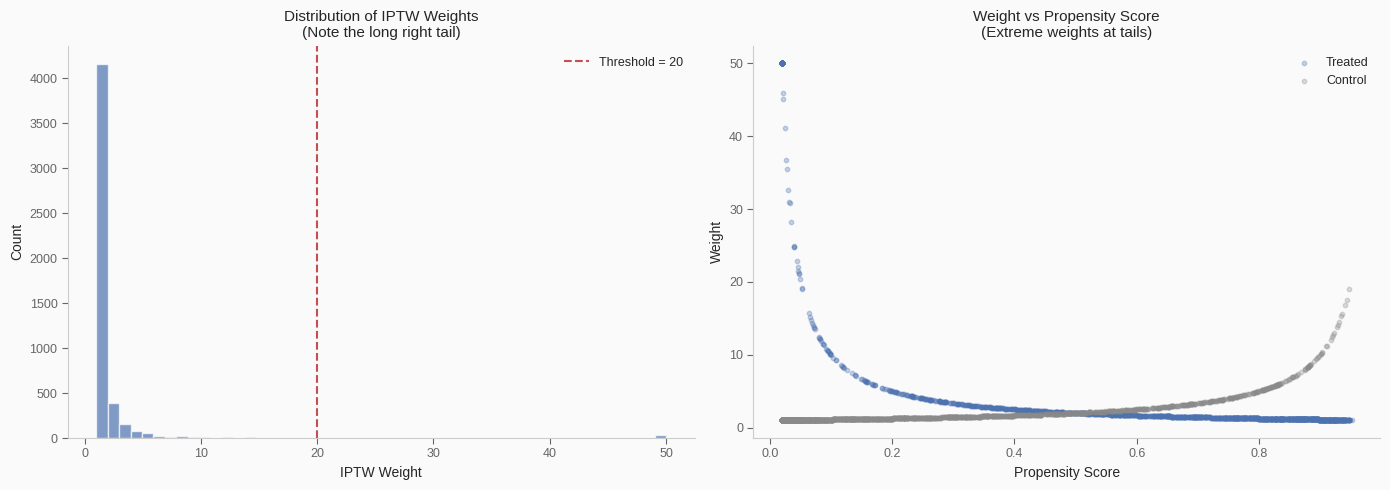

In [4]:
# Visualize weight distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight histogram
ax = axes[0]
ax.hist(email['weight'], bins=50, color=COLORS['blue'], alpha=0.7, edgecolor='white')
ax.axvline(x=20, color=COLORS['red'], linestyle='--', label='Threshold = 20')
ax.set_xlabel('IPTW Weight')
ax.set_ylabel('Count')
ax.set_title('Distribution of IPTW Weights\n(Note the long right tail)')
ax.legend()
apply_tufte_style(ax)

# Weight vs PS
ax = axes[1]
treated = email[email['em1'] == 1]
control = email[email['em1'] == 0]
ax.scatter(treated['em1_ps'], treated['weight'], alpha=0.3, s=10, 
           color=COLORS['blue'], label='Treated')
ax.scatter(control['em1_ps'], control['weight'], alpha=0.3, s=10, 
           color=COLORS['gray'], label='Control')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Weight')
ax.set_title('Weight vs Propensity Score\n(Extreme weights at tails)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Effective Sample Size

In [5]:
def effective_sample_size(weights):
    """
    Compute effective sample size from weights.
    
    n_eff = (sum w)^2 / sum(w^2)
    """
    return (np.sum(weights)**2) / np.sum(weights**2)

# Compute ESS
n_actual = len(email)
n_eff = effective_sample_size(email['weight'])

print("Effective Sample Size Analysis:")
print(f"  Actual sample size: {n_actual}")
print(f"  Effective sample size: {n_eff:.0f}")
print(f"  Efficiency: {100*n_eff/n_actual:.1f}%")

# ESS by treatment status
n_eff_treated = effective_sample_size(treated['weight'])
n_eff_control = effective_sample_size(control['weight'])

print(f"\n  Treated: {len(treated)} → {n_eff_treated:.0f} effective")
print(f"  Control: {len(control)} → {n_eff_control:.0f} effective")

Effective Sample Size Analysis:
  Actual sample size: 5000
  Effective sample size: 819
  Efficiency: 16.4%

  Treated: 1652 → 249 effective
  Control: 3348 → 1843 effective


### Replication Count in Resampled Data

In [6]:
# Resample with IPTW weights
np.random.seed(123)
weights_normalized = email['weight'] / email['weight'].sum()
indices = np.random.choice(len(email), size=10000, replace=True, p=weights_normalized)

# Count replications
unique, counts = np.unique(indices, return_counts=True)
replication_counts = pd.DataFrame({'index': unique, 'count': counts})

# Merge with original data
email_with_counts = email.copy()
email_with_counts['replication_count'] = 0
for idx, count in zip(unique, counts):
    email_with_counts.loc[idx, 'replication_count'] = count

print("Replication count distribution:")
print(email_with_counts['replication_count'].describe().round(1))
print(f"\nUnits appearing >10 times: {(email_with_counts['replication_count'] > 10).sum()}")

Replication count distribution:
count   5000.0000
mean       2.0000
std        4.8000
min        0.0000
25%        0.0000
50%        1.0000
75%        2.0000
max       64.0000
Name: replication_count, dtype: float64

Units appearing >10 times: 102


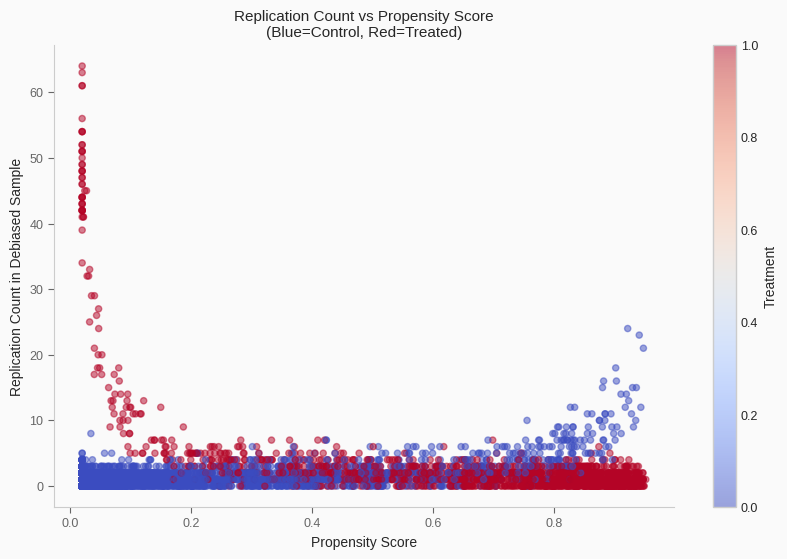


Interpretation: Treated units with low PS and control units with high PS
are replicated many times, dominating the pseudo-population.


In [7]:
# Visualize replication pattern
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    email_with_counts['em1_ps'], 
    email_with_counts['replication_count'],
    c=email_with_counts['em1'],
    cmap='coolwarm',
    alpha=0.5,
    s=20
)

ax.set_xlabel('Propensity Score')
ax.set_ylabel('Replication Count in Debiased Sample')
ax.set_title('Replication Count vs Propensity Score\n(Blue=Control, Red=Treated)')
apply_tufte_style(ax)
plt.colorbar(scatter, label='Treatment')
plt.show()

print("\nInterpretation: Treated units with low PS and control units with high PS")
print("are replicated many times, dominating the pseudo-population.")

### Positivity Violation Example

In [8]:
# Create data with positivity violation
# Treatment (em3) only assigned to age > 40

np.random.seed(42)
n = 5000

age = np.random.uniform(25, 55, n)
income = np.random.exponential(5000, n)

# em3 propensity: 0 for age < 40, positive for age >= 40
em3_ps = np.where(
    age < 40,
    0,  # ZERO probability for young customers
    1 / (1 + np.exp(-0.1*age + 0.0001*income + 1))
)
em3_ps = np.clip(em3_ps, 0, 0.95)

em3 = np.random.binomial(1, em3_ps)
converted = np.random.binomial(1, 0.3 + 0.005*age + 0.05*em3)

email_em3 = pd.DataFrame({
    'age': age,
    'income': income,
    'em3_ps': em3_ps,
    'em3': em3,
    'converted': converted
})

print("Positivity Violation Diagnosis:")
print(f"  Customers age < 40: {(age < 40).sum()}")
print(f"  Treated customers age < 40: {((age < 40) & (em3 == 1)).sum()}")
print(f"  Customers with PS = 0: {(em3_ps == 0).sum()}")

Positivity Violation Diagnosis:
  Customers age < 40: 2500
  Treated customers age < 40: 0
  Customers with PS = 0: 2500


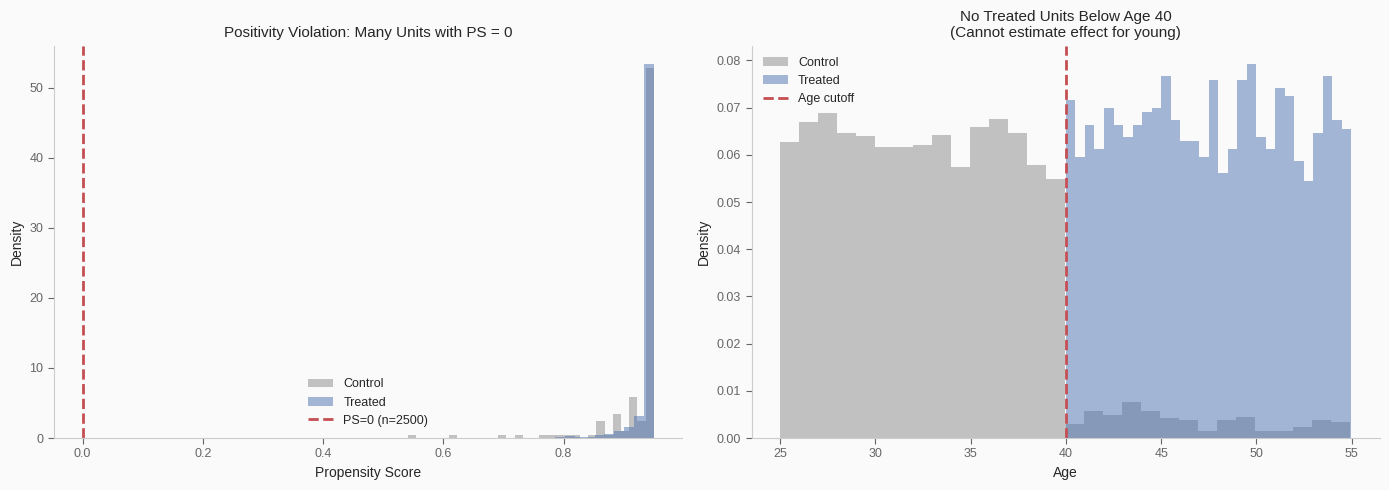

In [9]:
# Visualize positivity violation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PS distribution by treatment
ax = axes[0]
for em3_val, color, label in [(0, COLORS['gray'], 'Control'), (1, COLORS['blue'], 'Treated')]:
    subset = email_em3[email_em3['em3'] == em3_val]['em3_ps']
    subset_nonzero = subset[subset > 0]
    if len(subset_nonzero) > 0:
        ax.hist(subset_nonzero, bins=30, alpha=0.5, color=color, label=label, density=True)
ax.axvline(x=0, color=COLORS['red'], linestyle='--', linewidth=2, 
           label=f'PS=0 (n={(em3_ps == 0).sum()})')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.set_title('Positivity Violation: Many Units with PS = 0')
ax.legend()
apply_tufte_style(ax)

# Age distribution by treatment
ax = axes[1]
for em3_val, color, label in [(0, COLORS['gray'], 'Control'), (1, COLORS['blue'], 'Treated')]:
    subset = email_em3[email_em3['em3'] == em3_val]['age']
    ax.hist(subset, bins=30, alpha=0.5, color=color, label=label, density=True)
ax.axvline(x=40, color=COLORS['red'], linestyle='--', linewidth=2, label='Age cutoff')
ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.set_title('No Treated Units Below Age 40\n(Cannot estimate effect for young)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

---

## 4. Implementation {#implementation}

### Weight Trimming

In [10]:
def iptw_ate_trimmed(outcome, treatment, propensity_score, max_weight=None, 
                      ps_bounds=None, normalized=True):
    """
    IPTW ATE with optional weight trimming and PS bounds.
    
    Parameters
    ----------
    outcome : array
        Outcome variable
    treatment : array
        Binary treatment
    propensity_score : array
        Propensity scores
    max_weight : float or None
        Maximum allowed weight (clip above this)
    ps_bounds : tuple or None
        (lower, upper) bounds for PS (exclude units outside)
    normalized : bool
        Use Hajek estimator
        
    Returns
    -------
    dict
        ate, mu1, mu0, n_included, n_excluded
    """
    T = np.asarray(treatment)
    Y = np.asarray(outcome)
    e = np.asarray(propensity_score)
    
    # Apply PS bounds (restriction to common support)
    if ps_bounds is not None:
        mask = (e >= ps_bounds[0]) & (e <= ps_bounds[1])
    else:
        mask = np.ones(len(Y), dtype=bool)
    
    T = T[mask]
    Y = Y[mask]
    e = e[mask]
    
    # Compute weights
    weights = np.where(T == 1, 1 / e, 1 / (1 - e))
    
    # Apply weight trimming
    if max_weight is not None:
        weights = np.clip(weights, 0, max_weight)
    
    # Estimate
    if normalized:
        mu1 = np.sum(Y * T * weights) / np.sum(T * weights) if np.sum(T * weights) > 0 else np.nan
        mu0 = np.sum(Y * (1 - T) * weights) / np.sum((1 - T) * weights) if np.sum((1 - T) * weights) > 0 else np.nan
    else:
        n = len(Y)
        mu1 = np.sum(Y * T * weights) / n
        mu0 = np.sum(Y * (1 - T) * weights) / n
    
    return {
        'ate': mu1 - mu0,
        'mu1': mu1,
        'mu0': mu0,
        'n_included': mask.sum(),
        'n_excluded': (~mask).sum() if ps_bounds else 0
    }

# Compare approaches
print("ATE Estimates with Different Approaches:")
print("-" * 60)

# No trimming
result_raw = iptw_ate_trimmed(email['converted'], email['em1'], email['em1_ps'])
print(f"No trimming:           ATE = {result_raw['ate']:.4f}")

# Weight trimmed at 10
result_trim10 = iptw_ate_trimmed(email['converted'], email['em1'], email['em1_ps'], max_weight=10)
print(f"Weight trimmed at 10:  ATE = {result_trim10['ate']:.4f}")

# Weight trimmed at 20
result_trim20 = iptw_ate_trimmed(email['converted'], email['em1'], email['em1_ps'], max_weight=20)
print(f"Weight trimmed at 20:  ATE = {result_trim20['ate']:.4f}")

# PS bounds [0.05, 0.95]
result_bounds = iptw_ate_trimmed(email['converted'], email['em1'], email['em1_ps'], ps_bounds=(0.05, 0.95))
print(f"PS bounds [.05, .95]:  ATE = {result_bounds['ate']:.4f} (n={result_bounds['n_included']}, excl={result_bounds['n_excluded']})")

ATE Estimates with Different Approaches:
------------------------------------------------------------
No trimming:           ATE = 0.0010
Weight trimmed at 10:  ATE = -0.0015
Weight trimmed at 20:  ATE = -0.0005
PS bounds [.05, .95]:  ATE = -0.0026 (n=3179, excl=1821)


### Variance Comparison via Bootstrap

In [11]:
def bootstrap_iptw_ate(outcome, treatment, propensity_score, max_weight=None, 
                        n_bootstrap=500, seed=42):
    """
    Bootstrap confidence interval for IPTW ATE.
    """
    np.random.seed(seed)
    n = len(outcome)
    
    estimates = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        result = iptw_ate_trimmed(
            outcome[idx], treatment[idx], propensity_score[idx],
            max_weight=max_weight, normalized=True
        )
        if not np.isnan(result['ate']):
            estimates.append(result['ate'])
    
    estimates = np.array(estimates)
    return {
        'mean': np.mean(estimates),
        'std': np.std(estimates),
        'ci_lower': np.percentile(estimates, 2.5),
        'ci_upper': np.percentile(estimates, 97.5)
    }

# Compare variance
print("Bootstrap SE Comparison (500 bootstrap samples):")
print("-" * 60)

Y = email['converted'].values
T = email['em1'].values
PS = email['em1_ps'].values

for label, max_w in [('No trim', None), ('Trim at 10', 10), ('Trim at 20', 20)]:
    boot = bootstrap_iptw_ate(Y, T, PS, max_weight=max_w, n_bootstrap=500)
    print(f"{label:15s}: ATE = {boot['mean']:.4f} (SE = {boot['std']:.4f}), "
          f"95% CI = [{boot['ci_lower']:.4f}, {boot['ci_upper']:.4f}]")

Bootstrap SE Comparison (500 bootstrap samples):
------------------------------------------------------------
No trim        : ATE = 0.0012 (SE = 0.0027), 95% CI = [-0.0042, 0.0065]


Trim at 10     : ATE = -0.0012 (SE = 0.0034), 95% CI = [-0.0082, 0.0052]


Trim at 20     : ATE = -0.0002 (SE = 0.0031), 95% CI = [-0.0065, 0.0057]


### Handling Positivity Violations

In [12]:
# Restrict to common support region for em3 example
print("Handling Positivity Violation for em3:")
print("-" * 60)

# Full sample (problematic)
try:
    # Avoid division by zero
    ps_safe = np.clip(email_em3['em3_ps'], 0.001, 0.999)
    result_full = iptw_ate_trimmed(
        email_em3['converted'], email_em3['em3'], ps_safe
    )
    print(f"Full sample (problematic): ATE = {result_full['ate']:.4f}")
except Exception as e:
    print(f"Full sample error: {e}")

# Restrict to age >= 40 (where common support exists)
email_restricted = email_em3[email_em3['age'] >= 40]
result_restricted = iptw_ate_trimmed(
    email_restricted['converted'], 
    email_restricted['em3'], 
    email_restricted['em3_ps']
)
print(f"Restricted (age >= 40):    ATE = {result_restricted['ate']:.4f} (n={len(email_restricted)})")

# Check balance in restricted sample
print(f"\nBalance check (restricted sample):")
print(f"  Correlation (age, em3): {email_restricted['age'].corr(email_restricted['em3']):.3f}")
print(f"  Correlation (income, em3): {email_restricted['income'].corr(email_restricted['em3']):.3f}")

Handling Positivity Violation for em3:
------------------------------------------------------------
Full sample (problematic): ATE = 0.0727
Restricted (age >= 40):    ATE = 0.0474 (n=2500)

Balance check (restricted sample):
  Correlation (age, em3): 0.055
  Correlation (income, em3): -0.095


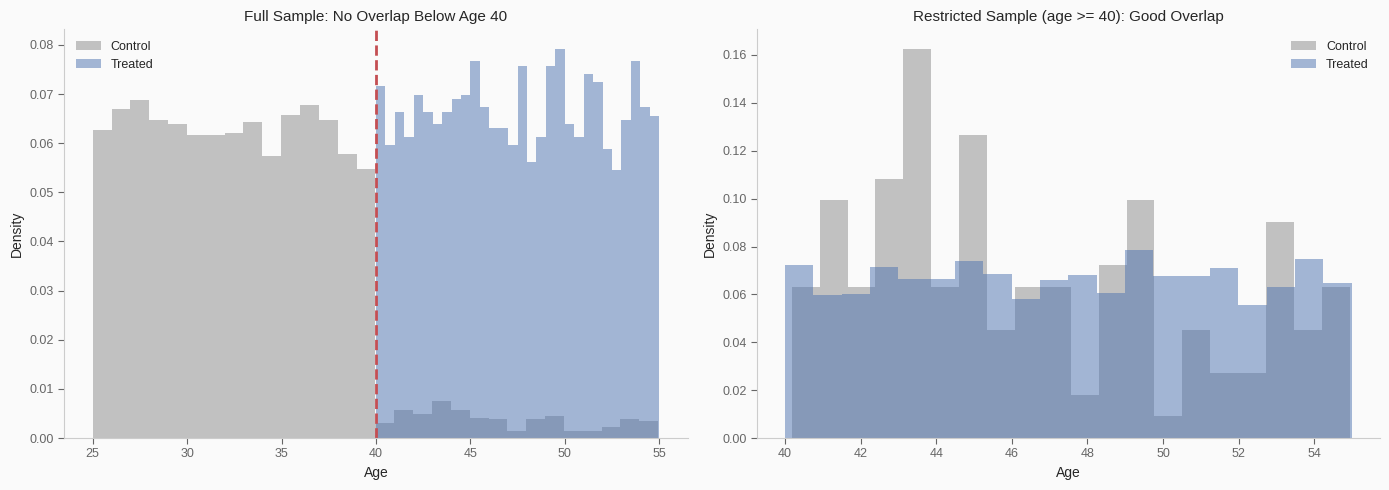

In [13]:
# Visualize balance before/after restriction
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before restriction
ax = axes[0]
for em3_val, color, label in [(0, COLORS['gray'], 'Control'), (1, COLORS['blue'], 'Treated')]:
    subset = email_em3[email_em3['em3'] == em3_val]['age']
    ax.hist(subset, bins=30, alpha=0.5, color=color, label=label, density=True)
ax.axvline(x=40, color=COLORS['red'], linestyle='--', linewidth=2)
ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.set_title('Full Sample: No Overlap Below Age 40')
ax.legend()
apply_tufte_style(ax)

# After restriction
ax = axes[1]
for em3_val, color, label in [(0, COLORS['gray'], 'Control'), (1, COLORS['blue'], 'Treated')]:
    subset = email_restricted[email_restricted['em3'] == em3_val]['age']
    ax.hist(subset, bins=20, alpha=0.5, color=color, label=label, density=True)
ax.set_xlabel('Age')
ax.set_ylabel('Density')
ax.set_title('Restricted Sample (age >= 40): Good Overlap')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

```
★ Key Takeaway ────────────────────────────────────────────────
Practical IPTW Recommendations:

1. **Check PS distribution** - Plot by treatment status
2. **Calculate effective sample size** - Warn if < 0.5 × actual n
3. **Consider trimming** - Trade-off bias vs variance
4. **Restrict if needed** - Change estimand explicitly
5. **Report sensitivity** - Show results with/without trimming

**Golden rule**: Design experiments to avoid extreme PS!
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: What happens when propensity scores are very close to 0 or 1?

<details>
<summary>Solution</summary>

**Mathematical problem**:
- Weight = 1/PS for treated
- PS → 0 means weight → ∞

**Practical consequences**:

1. **Extreme weights**
   - Single unit dominates entire analysis
   - Removing that unit changes results drastically

2. **High variance**
   - Effective sample size collapses
   - Confidence intervals explode

3. **Positivity violation**
   - PS = 0 means some units NEVER get treatment
   - Cannot estimate counterfactual for that subpopulation

**Remedies**:

| Approach | Pro | Con |
|----------|-----|-----|
| Weight trimming | Reduces variance | Introduces bias |
| PS bounds | Clear estimand | Loses observations |
| Doubly robust | More stable | Still needs overlap |
| Better design | Root cause fix | Only for new experiments |

</details>

### Q2: Should you trim weights or restrict the sample?

<details>
<summary>Solution</summary>

**Weight trimming**:
- Set max weight (e.g., 10 or 20)
- Keeps all observations
- Introduces bias toward over-trimmed group
- Estimand unclear ("approximate ATE")

**Sample restriction**:
- Exclude units with extreme PS
- Clear estimand: ATE on overlap population
- Loses observations explicitly
- More transparent about what you're estimating

**Recommendation**:

1. **Prefer restriction** when:
   - Positivity is clearly violated (PS = 0)
   - You're okay estimating effect for overlap population
   - Academic setting requiring clear estimand

2. **Consider trimming** when:
   - No true positivity violation, just extreme weights
   - Applied setting with variance concerns
   - Report sensitivity to trimming threshold

**Always**: Report both analyses as sensitivity check!

</details>

### Q3: How do you check for positivity violations?

<details>
<summary>Solution</summary>

**Visual checks**:

1. **PS distribution by treatment**
   ```python
   sns.histplot(data=df, x='ps', hue='treatment', stat='density')
   ```
   - Good: Overlapping distributions
   - Bad: Separated distributions, peaks at 0 or 1

2. **Covariate distributions**
   ```python
   sns.pairplot(df[covariates + ['treatment']], hue='treatment')
   ```
   - Look for regions with only treated or only control

**Quantitative checks**:

1. **Min/max PS**
   - Check min(PS) > ε and max(PS) < 1-ε
   - Typical ε = 0.01 to 0.10

2. **Effective sample size**
   - n_eff = (Σw)² / Σw²
   - If n_eff << n, positivity issues likely

3. **Weight distribution**
   - Check for extreme weights (> 20-50)
   - Flag if >5% of sample has weight > 10

</details>

### Q4: In practice, when is positivity violation acceptable?

<details>
<summary>Solution</summary>

**Academic research**: Usually problematic
- Need generalizable conclusions
- Must be transparent about limited external validity

**Industry applications**: Often acceptable!

**Examples where it's fine**:

1. **Targeted marketing**
   - Email-3 designed for age > 40
   - You don't WANT to estimate effect on young customers
   - Business relevance > statistical purity

2. **Lending decisions**
   - Don't give large loans to high-risk customers
   - Interest in effect for creditworthy borrowers
   - Positivity violation is by design

3. **Medical treatment**
   - Drug contraindicated for certain patients
   - Focus on eligible population
   - Ethical to exclude contraindicated groups

**Key principle**: Positivity violation is fine IF:
- You're clear about the target population
- You don't generalize beyond common support
- The restricted population is policy-relevant

</details>

### Q5: Why is IPTW good at revealing positivity problems?

<details>
<summary>Solution</summary>

**IPTW makes positivity problems explicit**:

1. **Weights are observable**
   - Can literally see w = 1/0.01 = 100
   - Other methods hide this in matrix algebra

2. **PS distribution is diagnostic**
   - Simple plot reveals overlap
   - Harder to visualize with regression adjustment

3. **Effective sample size is calculable**
   - Direct measure of information loss
   - n_eff << n signals problem

**Contrast with regression**:

| IPTW | Regression |
|------|------------|
| Extreme weights visible | Hidden extrapolation |
| PS plot diagnostic | Need to examine X space |
| Fails obviously | Fails silently |

**Quote (Imbens)**: "Propensity score methods have the advantage of 
making the assumptions transparent and easy to assess."

**Implication**: Even if you use regression, check propensity scores!

</details>

---

## 6. References {#references}

[^1]: Crump, R. K., Hotz, V. J., Imbens, G. W., & Mitnik, O. A. (2009). Dealing with 
      Limited Overlap in Estimation of Average Treatment Effects. *Biometrika*.

[^2]: Cole, S. R., & Hernan, M. A. (2008). Constructing Inverse Probability Weights 
      for Marginal Structural Models. *American Journal of Epidemiology*.

[^3]: Petersen, M. L., Porter, K. E., Gruber, S., Wang, Y., & Van Der Laan, M. J. (2012). 
      Diagnosing and Responding to Violations in the Positivity Assumption. 
      *Statistical Methods in Medical Research*.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: 
      Debiasing with Propensity Score.